### CODE SUMMARY


READ ALL DATA                                                                                                                   

CONVERT RA, DEC TO SUITABLE DATA_VECTORS FROM THE DATA                                                                          

DIVIDE ICECUBE DATA TO 441 LENGTH VECTORS TO MATCH MSPSRDATA VECTOR SIZE                                                        

CIRCULARLY ITERATE THROUGH ICECUBE VECTORS TO GET COSINE(SPACE ANGLES) AT 441 x 441 COSINE(ANGLES) PER ITERATION FOR 2373 ITERATIONS

The data is binned between 0 and 7.35 degrees into 6 equispaced cos (theta) bins

CALCULATE THE AVERAGE OF LAST 5 BINS WHICH CONSTITUTE THE BACKGROUND.

PLOT THE DATA IN A GRAPH                                                                                                     


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#import astropy.coordinates as asc
from numba import jit, cuda
from numba import vectorize

In [11]:
path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
 "IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]

In [12]:
file = filenames[0]
f = open(os.path.join(path, file), 'r')

lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []

In [13]:
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()

In [14]:
icdata = pd.DataFrame(content, columns=column)

In [15]:

f = open("10milsecpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines[3].split()

for line in lines[:]:
    content.append(line.split())

#the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]

In [16]:
def hvovec(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    return a

In [17]:
icra = [float(i) for i in icdata['RA[deg]']]
icdec = [float(i) for i in icdata['Dec[deg]']]
icra.extend([0]*(243))
icdec.extend([0]*(243))
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icdata = []
mspdata = []

In [18]:
lg = int(len(icra)/len(msra))
p = len(msra)
r= []
for k in range(lg):
    ilo = icra[k * p  :p * k + p]
    ila = icdec[k * p  :p * k + p]
    lo =[]
    la = []
    for j in range(k,p + k):#441
                lo = [msra[(i + j)%p] for i in range(0,p)]
                la = [msdec[(i + j)%p] for i in range(0,p)]
                r.append(hvovec(ilo, ila, lo, la))

icra.clear()
icdec.clear()
msra.clear()
msdec.clear()
#r = [r[i].compute() for i in range(len(r))]


In [19]:
r = np.ravel(r)

The data is binned between 0 and 7.35 degrees into 6 equispaced cos (theta) bins

(The bin closest to 0 corresponds to 3 degrees)

The average of the last 5 bins will constitute the background.

In [20]:
nbins = np.linspace(np.cos(np.radians(7.35)), np.cos(0),  7)


In [21]:
freq , _ = np.histogram(r, nbins)

freq1 = freq[:-1]
midpt = [(nbins[i+1] + nbins[i])/2.0 for i in range(len(nbins) - 1)]
midpt = np.array(midpt[:-1])
mean = np.dot(freq1, midpt)/float(np.sum(midpt))
print(f'BACKGROUND: {mean}')
print(f'SIGNAL: {freq[-1]}')

BACKGROUND: 348694.8656082816
SIGNAL: 352904


BACKGROUND = MEAN OF LAST 5 BINS  = 348694.8656082816


(LAST 5 FROM RIGHT i.e from 0.992 to 0.999 or 7.35 to 2.99 degrees)

SIGNAL: 352904

### COSINE(SPACE ANGLE) DISTRIBUTION

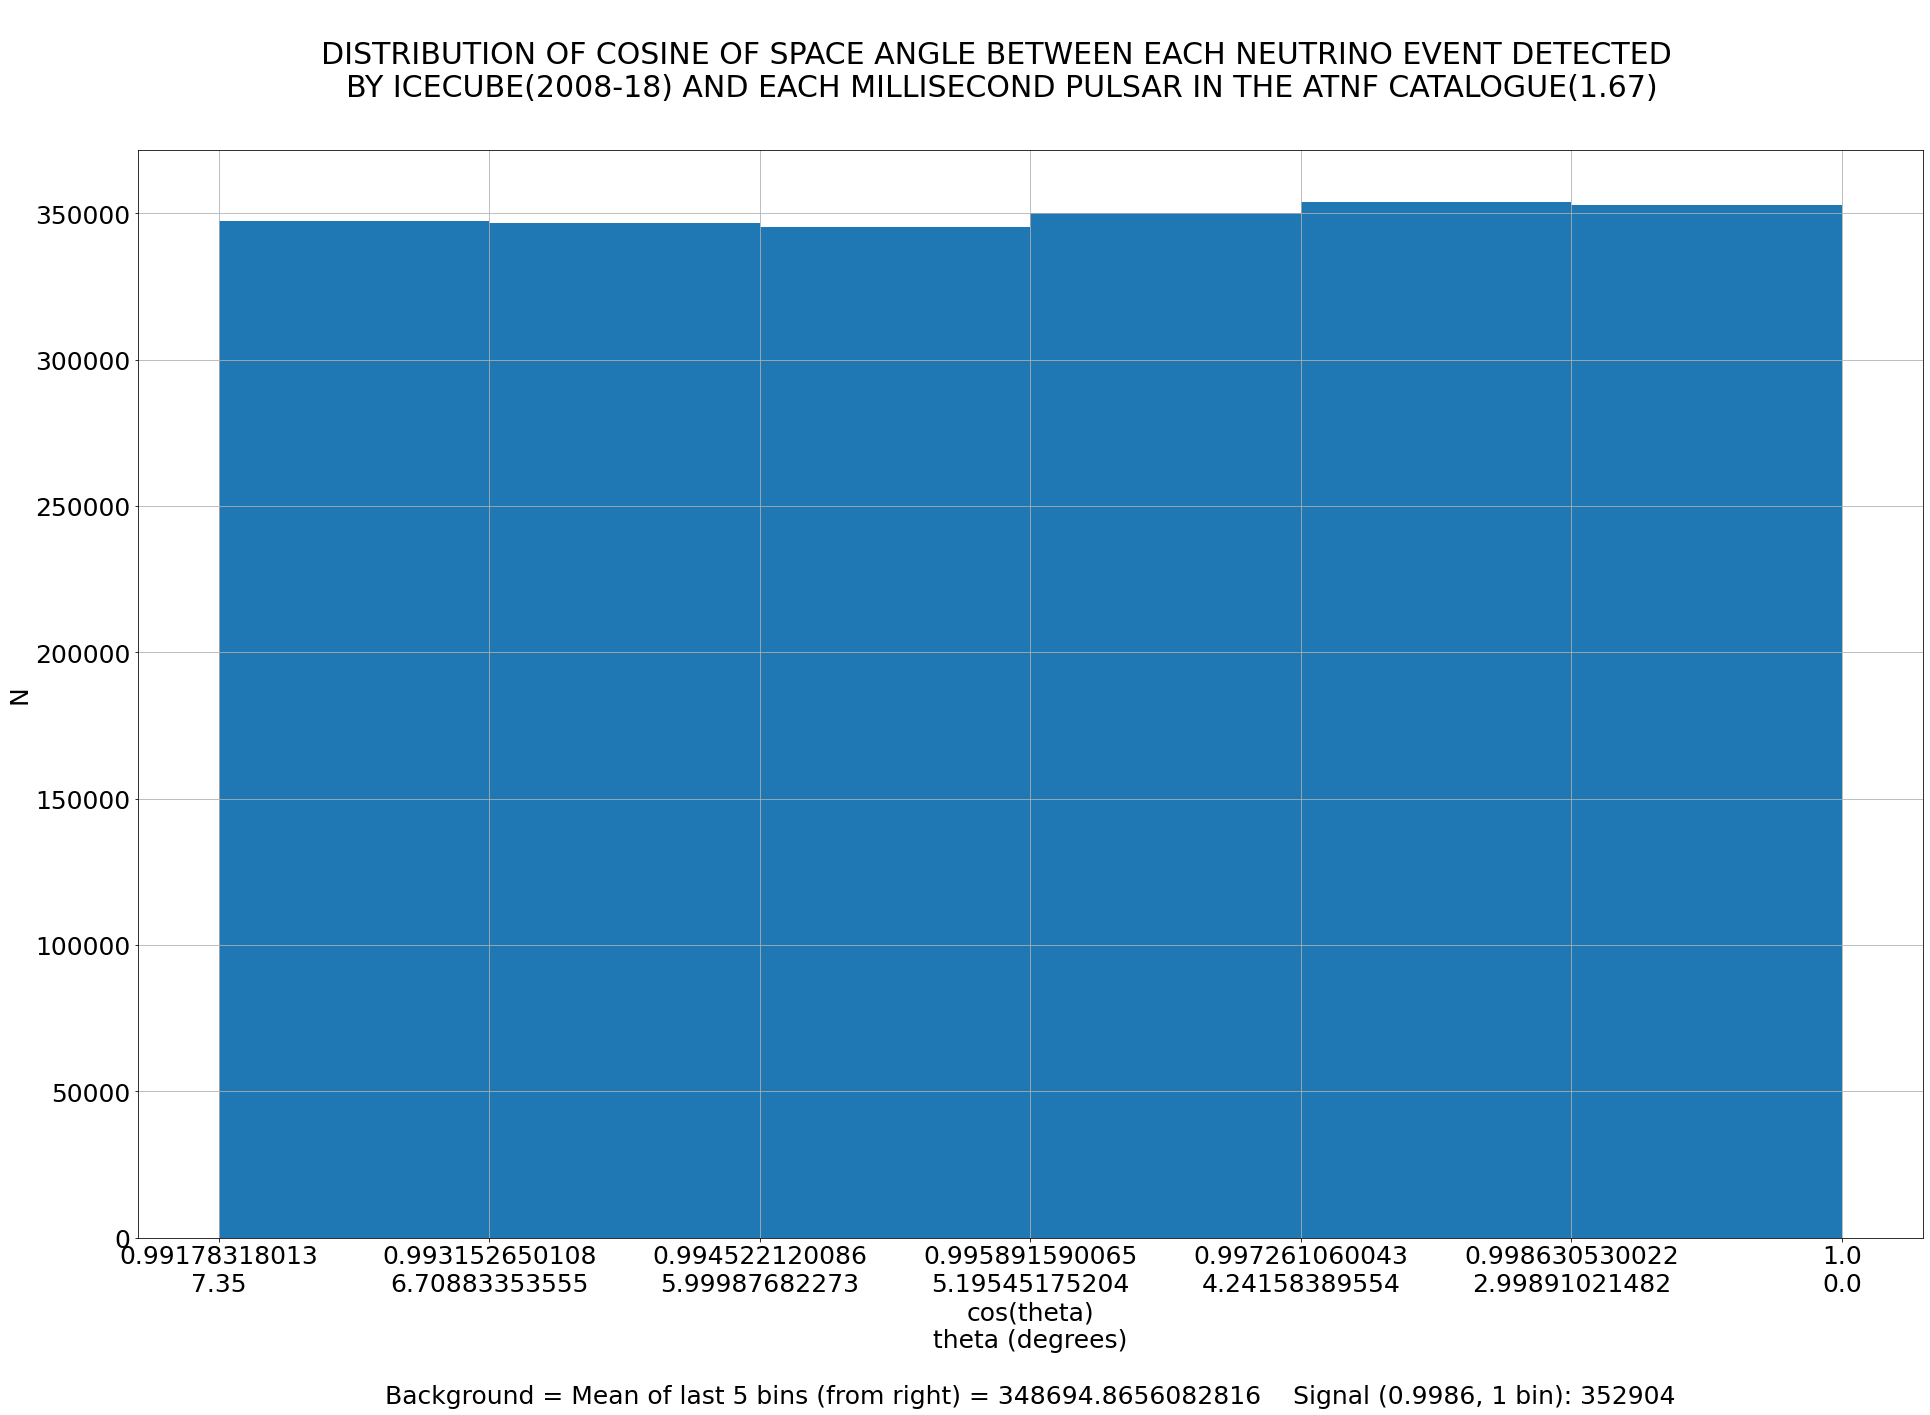

In [23]:
plt.figure(figsize=(32,20))
plt.rcParams.update({'font.size': 25})
nb = ['0.99178318013\n7.35', '0.993152650108\n6.70883353555', '0.994522120086\n5.99987682273', '0.995891590065\n5.19545175204', '0.997261060043\n4.24158389554', '0.998630530022\n2.99891021482', '1.0\n0.0']
#plt.hist(r, bins= nbins, edgecolor="black")
plt.stairs(freq, nbins, fill=True)
plt.xlabel(f"cos(theta)\ntheta (degrees)\n\nBackground = Mean of last 5 bins (from right) = {mean}    Signal (0.9986, 1 bin): {freq[-1]}")
plt.ylabel("N")
plt.xticks(nbins, nb)
plt.suptitle('\nDISTRIBUTION OF COSINE OF SPACE ANGLE BETWEEN EACH NEUTRINO EVENT DETECTED \n'
                                +'BY ICECUBE(2008-18) AND EACH MILLISECOND PULSAR IN THE ATNF CATALOGUE(1.67)')
plt.grid(True, which="both")
#plt.show()
plt.savefig('output2b', facecolor='w')